# Learning to Control a Dynamical System

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install --upgrade matplotlib

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

## Typical scenario. Off policy control learning

In a typical real world control setting, due to cost and operational concerns, there is not an opportunity to directly interact with the system to learn a controller. In this scenario, the system is perturbed for some amount of time to collect measurements representative of the system state space, system identification is performed, and a controller is created based on the fitted model created via system identification. In the following cells we walk through the three stage process of generating data, system identification, and control policy learning using neuromancer. 

## Instantiate a system emulator from neuromancer.psl

/mnt/c/Users/tuor369/gitland/neuromancer_wwu/neuromancer/src/neuromancer/psl/signals.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(torch.tensor(x)).numpy()


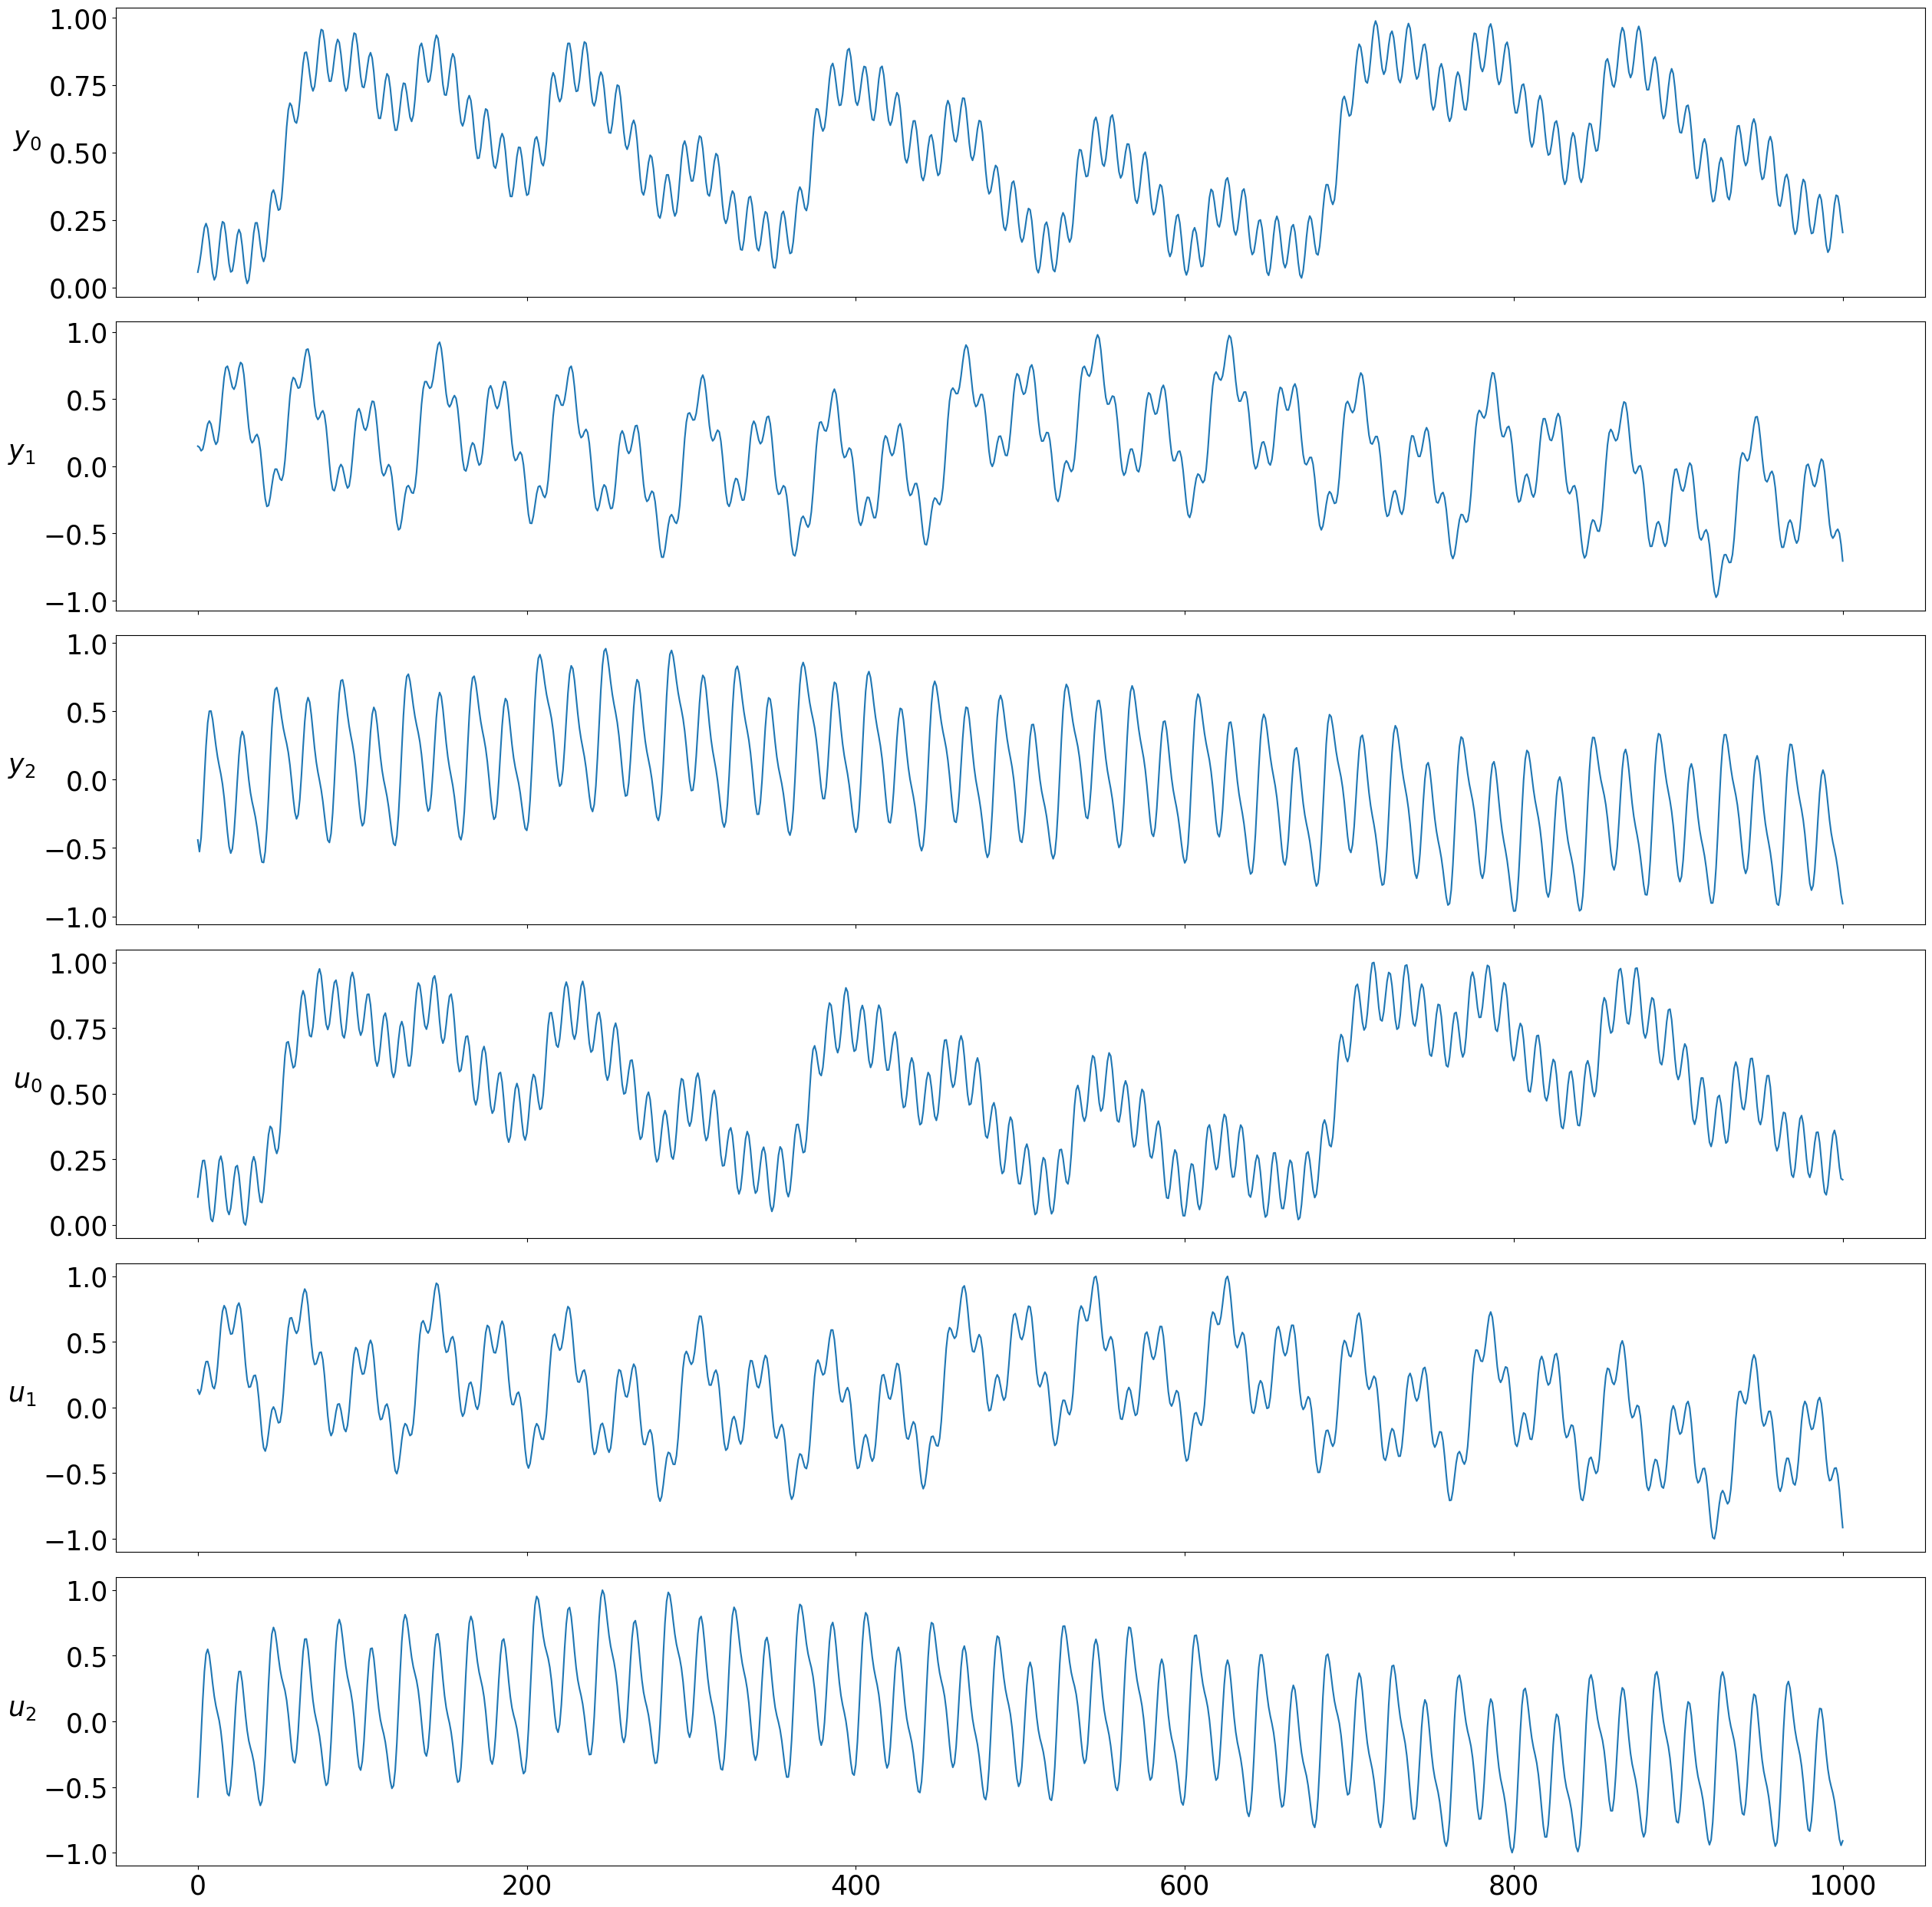

In [1]:
from neuromancer.psl.nonautonomous import Actuator
from neuromancer.dataset import DictDataset
sys = Actuator()
sys.show()

# Define a simple neural ODE model of the system

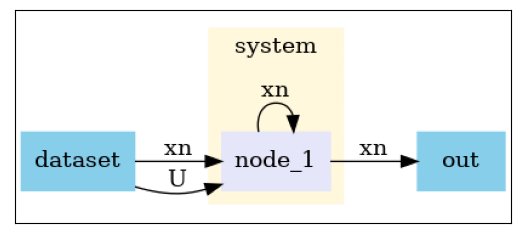

In [2]:
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dynamics import integrators
import torch

dx = blocks.MLP(sys.nx + sys.nu, sys.nx, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU,
              hsizes=[20 for h in range(3)])
interp_u = lambda tq, t, u: u
integrator = integrators.Euler(dx, h=torch.tensor(0.1), interp_u=interp_u)
system_node = Node(integrator, ['xn', 'U'], ['xn'])
model = System([system_node])
model.show()

# Generate datasets representative of system behavior

/mnt/c/Users/tuor369/gitland/neuromancer_wwu/neuromancer/src/neuromancer/psl/signals.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(torch.tensor(x)).numpy()


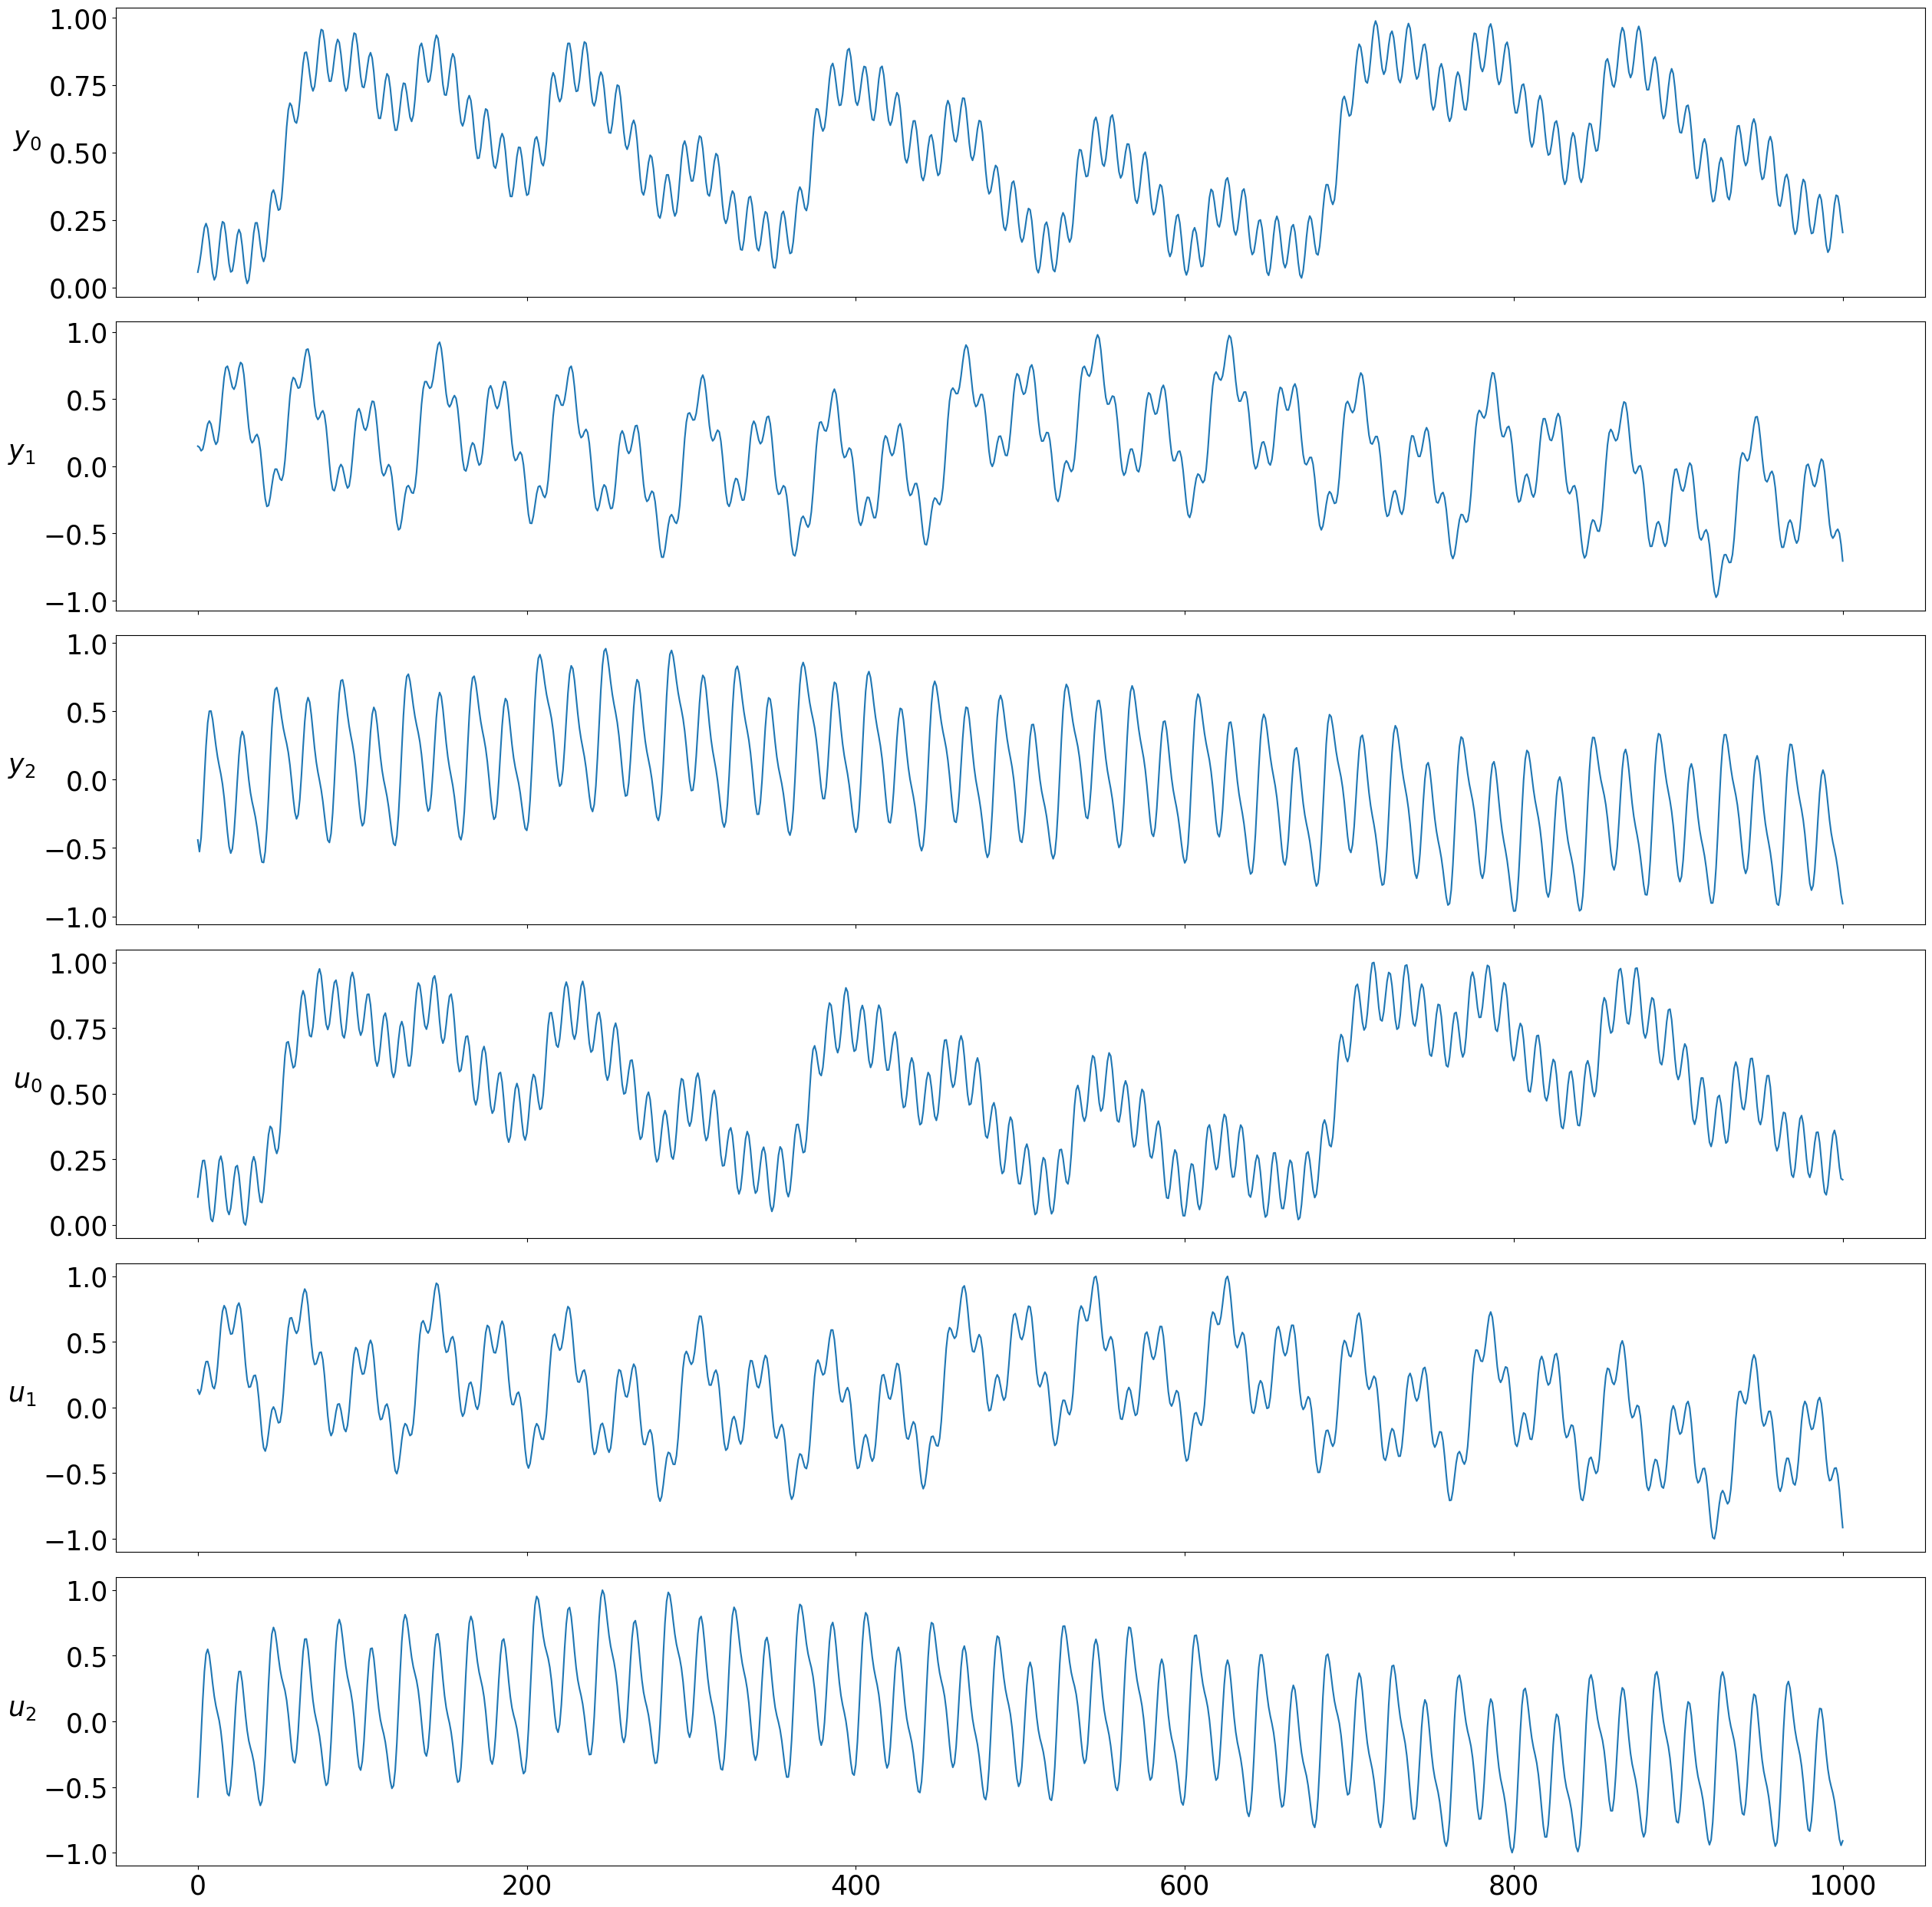

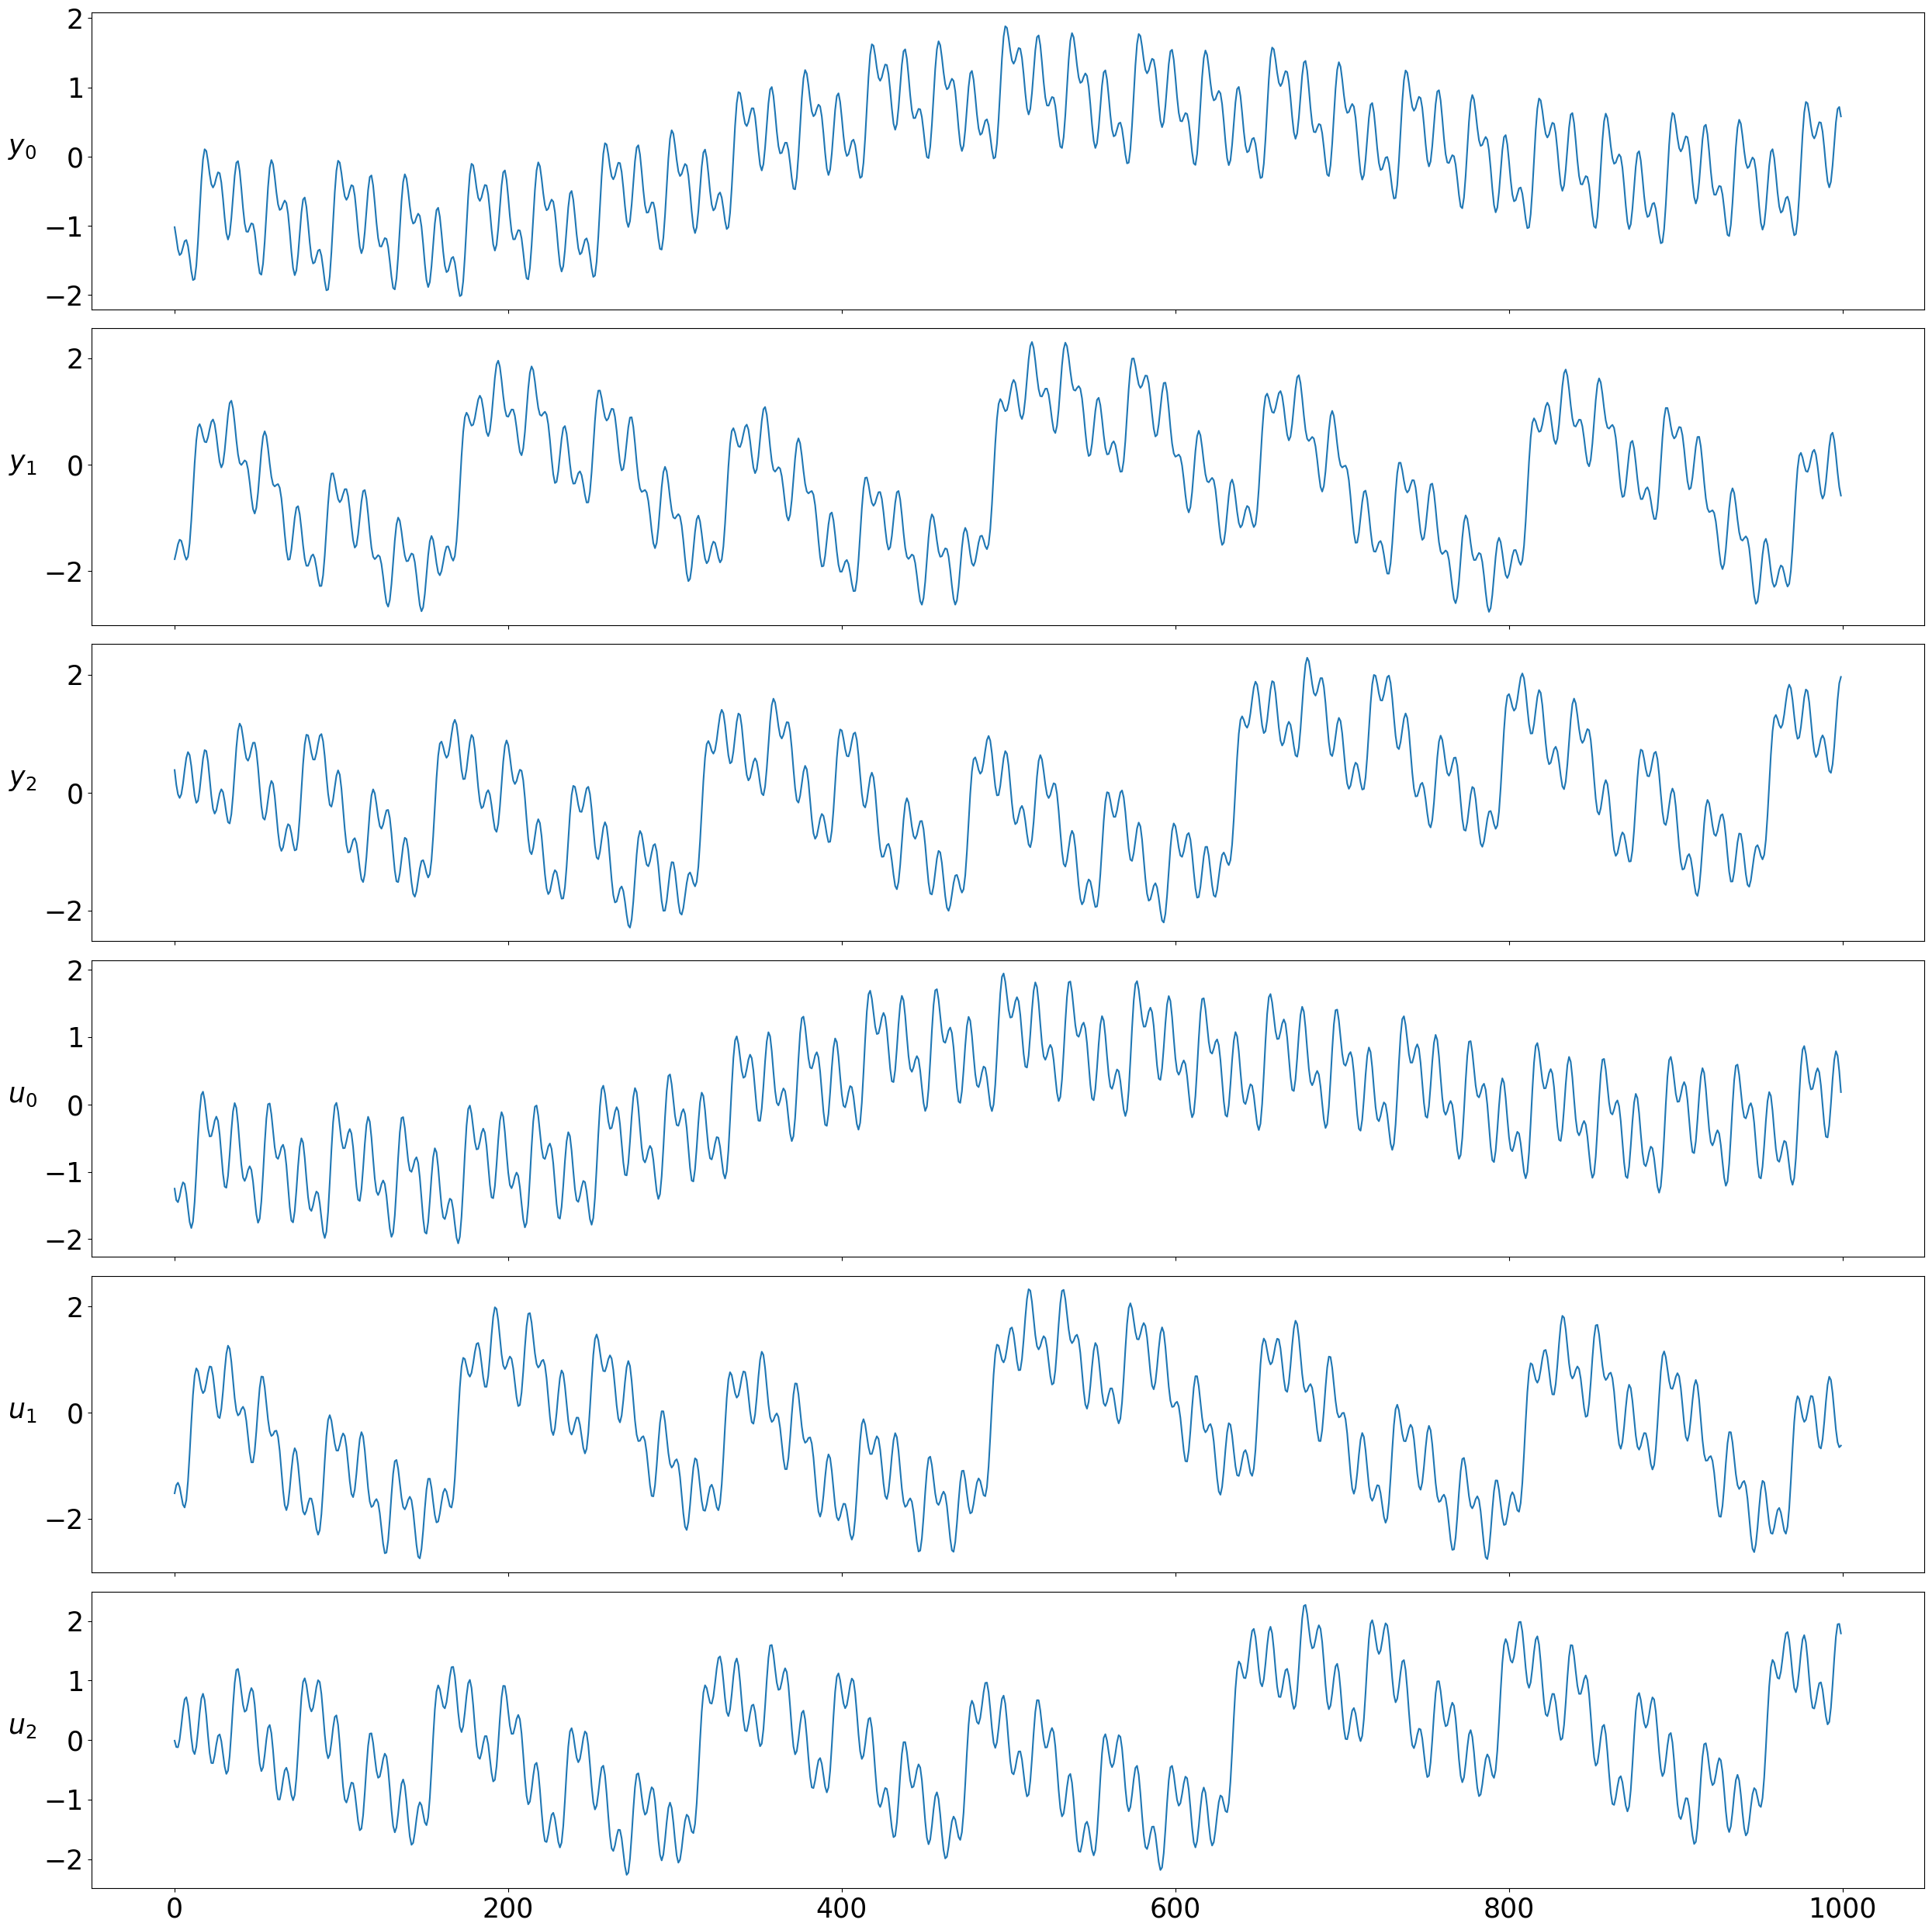

In [3]:
train_data, dev_data, test_data = [sys.simulate(nsim=1000) for i in range(3)]
sys.show()

from torch.utils.data import DataLoader
train_data, dev_data, test_data = [sys.normalize(d) for d in [train_data, dev_data, test_data]]
sys.show(train_data)
# Set up the data to be in samples of 10 contiguous time steps (100 samples with 10 time steps each last dim is dimension of the measured variable)
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(100, 10, 3)
    d['U'] = d['U'].reshape(100, 10, 3)
    d['Y'] = d['Y'].reshape(100, 10, 3)
    d['xn'] = d['X'][:, 0:1, :] # Add an initial condition to start the system loop
    d['Time'] = d['Time'].reshape(100, -1)

train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader, test_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset, dev_dataset]]


# Define the optimization problem

In [4]:
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss

# Nstep rollout predictions from the model
xpred = variable('xn')[:, :-1, :]
# Ground truth data
xtrue = variable('X')

loss = (xpred == xtrue) ^ 2
loss.update_name('loss')

obj = PenaltyLoss([loss], [])
problem = Problem([model], obj)

## Minimize the system identification problem

In [5]:
from neuromancer.trainer import Trainer
import torch.optim as optim

opt = optim.Adam(model.parameters(), 0.001)
trainer = Trainer(problem, train_loader, dev_loader, test_loader, opt,
                  epochs=1000,
                  patience=300,
                  train_metric='train_loss',
                  dev_metric='dev_loss',
                  test_metric='test_loss',
                  eval_metric='dev_loss')
best_model = trainer.train()

epoch: 0  train_loss: 0.44370779395103455
epoch: 1  train_loss: 0.44030651450157166
epoch: 2  train_loss: 0.43696996569633484
epoch: 3  train_loss: 0.43369612097740173
epoch: 4  train_loss: 0.4304833710193634
epoch: 5  train_loss: 0.42732885479927063
epoch: 6  train_loss: 0.4242285490036011
epoch: 7  train_loss: 0.4211772382259369
epoch: 8  train_loss: 0.4181690216064453
epoch: 9  train_loss: 0.4151977598667145
epoch: 10  train_loss: 0.4122574031352997
epoch: 11  train_loss: 0.40934228897094727
epoch: 12  train_loss: 0.40644702315330505
epoch: 13  train_loss: 0.4035665690898895
epoch: 14  train_loss: 0.40069639682769775
epoch: 15  train_loss: 0.3978322744369507
epoch: 16  train_loss: 0.39497053623199463
epoch: 17  train_loss: 0.3921078145503998
epoch: 18  train_loss: 0.38924136757850647
epoch: 19  train_loss: 0.38636884093284607
epoch: 20  train_loss: 0.38348835706710815
epoch: 21  train_loss: 0.3805982172489166
epoch: 22  train_loss: 0.3776971101760864
epoch: 23  train_loss: 0.3747841

epoch: 192  train_loss: 0.03704550117254257
epoch: 193  train_loss: 0.0366559661924839
epoch: 194  train_loss: 0.03627811372280121
epoch: 195  train_loss: 0.03591136261820793
epoch: 196  train_loss: 0.0355551615357399
epoch: 197  train_loss: 0.03520895540714264
epoch: 198  train_loss: 0.03487221151590347
epoch: 199  train_loss: 0.03454439714550972
epoch: 200  train_loss: 0.03422500565648079
epoch: 201  train_loss: 0.03391354903578758
epoch: 202  train_loss: 0.033609550446271896
epoch: 203  train_loss: 0.03331254422664642
epoch: 204  train_loss: 0.03302209451794624
epoch: 205  train_loss: 0.032737769186496735
epoch: 206  train_loss: 0.03245914354920387
epoch: 207  train_loss: 0.032185833901166916
epoch: 208  train_loss: 0.03191744163632393
epoch: 209  train_loss: 0.03165360167622566
epoch: 210  train_loss: 0.03139396011829376
epoch: 211  train_loss: 0.03113817609846592
epoch: 212  train_loss: 0.030885931104421616
epoch: 213  train_loss: 0.030636904761195183
epoch: 214  train_loss: 0.030

epoch: 384  train_loss: 0.0016801030142232776
epoch: 385  train_loss: 0.0016542075900360942
epoch: 386  train_loss: 0.0016289532650262117
epoch: 387  train_loss: 0.0016043222276493907
epoch: 388  train_loss: 0.0015802973648533225
epoch: 389  train_loss: 0.0015568616800010204
epoch: 390  train_loss: 0.0015339995734393597
epoch: 391  train_loss: 0.001511694397777319
epoch: 392  train_loss: 0.0014899317175149918
epoch: 393  train_loss: 0.0014686962822452188
epoch: 394  train_loss: 0.001447973889298737
epoch: 395  train_loss: 0.0014277497539296746
epoch: 396  train_loss: 0.0014080109540373087
epoch: 397  train_loss: 0.0013887438690289855
epoch: 398  train_loss: 0.0013699362752959132
epoch: 399  train_loss: 0.0013515749014914036
epoch: 400  train_loss: 0.0013336485717445612
epoch: 401  train_loss: 0.001316144480369985
epoch: 402  train_loss: 0.001299052033573389
epoch: 403  train_loss: 0.0012823600554838777
epoch: 404  train_loss: 0.0012660571373999119
epoch: 405  train_loss: 0.001250133267

epoch: 564  train_loss: 0.0004928378039039671
epoch: 565  train_loss: 0.0004916443140245974
epoch: 566  train_loss: 0.0004904617671854794
epoch: 567  train_loss: 0.0004892897559329867
epoch: 568  train_loss: 0.00048812830937094986
epoch: 569  train_loss: 0.00048697699094191194
epoch: 570  train_loss: 0.00048583606258034706
epoch: 571  train_loss: 0.00048470497131347656
epoch: 572  train_loss: 0.00048358371714130044
epoch: 573  train_loss: 0.0004824720090255141
epoch: 574  train_loss: 0.0004813697305507958
epoch: 575  train_loss: 0.000480276852613315
epoch: 576  train_loss: 0.00047919308417476714
epoch: 577  train_loss: 0.00047811836702749133
epoch: 578  train_loss: 0.000477052410133183
epoch: 579  train_loss: 0.00047599521349184215
epoch: 580  train_loss: 0.00047494666068814695
epoch: 581  train_loss: 0.000473906344268471
epoch: 582  train_loss: 0.00047287464258261025
epoch: 583  train_loss: 0.0004718507989309728
epoch: 584  train_loss: 0.0004708350170403719
epoch: 585  train_loss: 0.0

epoch: 744  train_loss: 0.000362616206984967
epoch: 745  train_loss: 0.0003621201030910015
epoch: 746  train_loss: 0.0003616252215579152
epoch: 747  train_loss: 0.0003611315041780472
epoch: 748  train_loss: 0.00036063921288587153
epoch: 749  train_loss: 0.0003601479984354228
epoch: 750  train_loss: 0.0003596581518650055
epoch: 751  train_loss: 0.00035916941124014556
epoch: 752  train_loss: 0.00035868174745701253
epoch: 753  train_loss: 0.00035819539334625006
epoch: 754  train_loss: 0.0003577102907001972
epoch: 755  train_loss: 0.00035722620668821037
epoch: 756  train_loss: 0.00035674337414093316
epoch: 757  train_loss: 0.00035626182216219604
epoch: 758  train_loss: 0.00035578131792135537
epoch: 759  train_loss: 0.0003553018905222416
epoch: 760  train_loss: 0.0003548236272763461
epoch: 761  train_loss: 0.0003543465572874993
epoch: 762  train_loss: 0.00035387062234804034
epoch: 763  train_loss: 0.0003533957351464778
epoch: 764  train_loss: 0.0003529219247866422
epoch: 765  train_loss: 0.

epoch: 924  train_loss: 0.0002882023109123111
epoch: 925  train_loss: 0.00028785347240045667
epoch: 926  train_loss: 0.00028750509954988956
epoch: 927  train_loss: 0.0002871573669835925
epoch: 928  train_loss: 0.0002868103329092264
epoch: 929  train_loss: 0.00028646361897699535
epoch: 930  train_loss: 0.0002861176908481866
epoch: 931  train_loss: 0.00028577217017300427
epoch: 932  train_loss: 0.00028542731888592243
epoch: 933  train_loss: 0.00028508290415629745
epoch: 934  train_loss: 0.0002847392170224339
epoch: 935  train_loss: 0.0002843960246536881
epoch: 936  train_loss: 0.0002840533561538905
epoch: 937  train_loss: 0.0002837112406268716
epoch: 938  train_loss: 0.00028336973628029227
epoch: 939  train_loss: 0.00028302878490649164
epoch: 940  train_loss: 0.0002826883865054697
epoch: 941  train_loss: 0.00028234836645424366
epoch: 942  train_loss: 0.0002820091031026095
epoch: 943  train_loss: 0.0002816702181007713
epoch: 944  train_loss: 0.0002813319442793727
epoch: 945  train_loss: 0

## Evaluate system model on 1000 time step rollout

/mnt/c/Users/tuor369/gitland/neuromancer_wwu/neuromancer/src/neuromancer/psl/signals.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(torch.tensor(x)).numpy()


{'Y': (1000, 3), 'X': (1000, 3), 'U': (1000, 3), 'Time': (1000,)}


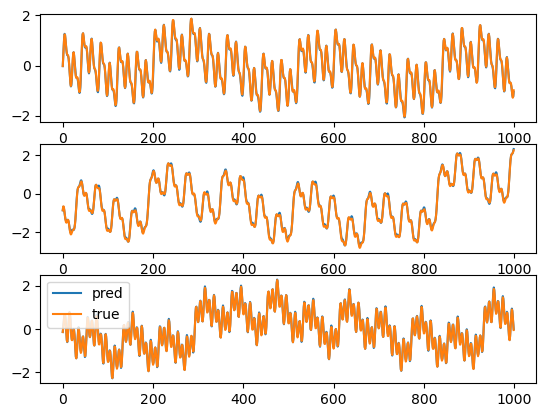

In [6]:
import torch
test_data = sys.normalize(sys.simulate(nsim=1000))
print({k: v.shape for k, v in test_data.items()})

test_data['X'] = test_data['X'].reshape(1, *test_data['X'].shape)
test_data['U'] = test_data['U'].reshape(1, *test_data['U'].shape)
test_data['xn'] = test_data['X'][:, 0:1, :]
test_data = {k: torch.tensor(v, dtype=torch.float32) for k, v in test_data.items()}
test_output = model(test_data)

import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_output['xn'][0, :-1, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['X'][0, :, v].detach().numpy(), label='true')
plt.legend()

## Create a closed loop system using the system model and a parametrized control policy


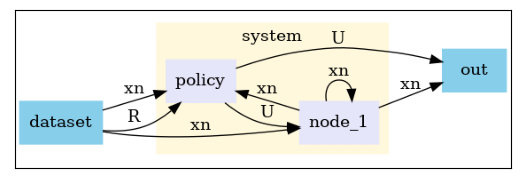

In [7]:
nx, nu = sys.nx, sys.nu

class Policy(torch.nn.Module):

    def __init__(self, insize, outsize):
        super().__init__()
        self.net = blocks.MLP(insize, outsize, bias=True, hsizes=[20, 20, 20])

    def forward(self, x, R):
        features = torch.cat([x, R], dim=-1)
        return self.net(features)

insize = 2*nx
policy = Policy(insize, nu)
policy_node = Node(policy, ['xn', 'R'], ['U'], name='policy')
cl_system = System([policy_node, system_node])
cl_system.show()

## Optimizing the control policy

For this simple Actuator system the same dataset can be used for learning a control policy as we used to learn the system model. Here we wish to optimize  controlling the system to some reference trajectory R.

In [8]:
train_dataset = DictDataset({'R': train_data['X'], 'X': train_data['X'], 'xn': train_data['xn']}, name='train')
dev_dataset = DictDataset({'R': dev_data['X'], 'X': train_data['X'], 'xn': dev_data['xn']}, name='dev')
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True) for d in [train_dataset, dev_dataset]]

In [9]:
opt = optim.Adam(policy.parameters(), 0.01)

tru = variable('xn')[:, 1:, :]
ref = variable('R')
u = variable('U')
loss = (ref == tru) ^ 2
loss.update_name('loss')

obj = PenaltyLoss([loss], [])
problem = Problem([cl_system], obj)

logout = ['loss']
trainer = Trainer(problem, train_loader, dev_loader, dev_loader, opt,
                  epochs=1000,
                  patience=1000,
                  train_metric='train_loss',
                  dev_metric='dev_loss',
                  test_metric='dev_loss',
                  eval_metric='dev_loss')

best_model = trainer.train()
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 1.011462926864624
epoch: 1  train_loss: 0.8372907042503357
epoch: 2  train_loss: 0.6739335656166077
epoch: 3  train_loss: 0.5135840177536011
epoch: 4  train_loss: 0.36352407932281494
epoch: 5  train_loss: 0.25825369358062744
epoch: 6  train_loss: 0.2298937439918518
epoch: 7  train_loss: 0.19880381226539612
epoch: 8  train_loss: 0.18602091073989868
epoch: 9  train_loss: 0.12027227878570557
epoch: 10  train_loss: 0.05790602043271065
epoch: 11  train_loss: 0.04189781844615936
epoch: 12  train_loss: 0.05804665759205818
epoch: 13  train_loss: 0.07193344831466675
epoch: 14  train_loss: 0.07374834269285202
epoch: 15  train_loss: 0.06738907098770142
epoch: 16  train_loss: 0.055911093950271606
epoch: 17  train_loss: 0.042564861476421356
epoch: 18  train_loss: 0.0321977324783802
epoch: 19  train_loss: 0.029420478269457817
epoch: 20  train_loss: 0.03327532112598419
epoch: 21  train_loss: 0.035698920488357544
epoch: 22  train_loss: 0.031891755759716034
epoch: 23  train_loss: 

epoch: 182  train_loss: 0.0002870854514185339
epoch: 183  train_loss: 0.000285353627987206
epoch: 184  train_loss: 0.0002836504718288779
epoch: 185  train_loss: 0.00028197572100907564
epoch: 186  train_loss: 0.00028032902628183365
epoch: 187  train_loss: 0.0002787093399092555
epoch: 188  train_loss: 0.00027711610891856253
epoch: 189  train_loss: 0.0002755493624135852
epoch: 190  train_loss: 0.0002740086638368666
epoch: 191  train_loss: 0.0002724937512539327
epoch: 192  train_loss: 0.0002710043918341398
epoch: 193  train_loss: 0.000269539887085557
epoch: 194  train_loss: 0.0002680999750737101
epoch: 195  train_loss: 0.00026668424834497273
epoch: 196  train_loss: 0.0002652922412380576
epoch: 197  train_loss: 0.0002639236336108297
epoch: 198  train_loss: 0.0002625782508403063
epoch: 199  train_loss: 0.00026125586009584367
epoch: 200  train_loss: 0.0002599558501970023
epoch: 201  train_loss: 0.00025867793010547757
epoch: 202  train_loss: 0.0002574217796791345
epoch: 203  train_loss: 0.0002

epoch: 361  train_loss: 0.0001935381442308426
epoch: 362  train_loss: 0.00019348401110619307
epoch: 363  train_loss: 0.0001934310421347618
epoch: 364  train_loss: 0.0001933791791088879
epoch: 365  train_loss: 0.00019332840747665614
epoch: 366  train_loss: 0.0001932787272380665
epoch: 367  train_loss: 0.00019323022570461035
epoch: 368  train_loss: 0.00019318267004564404
epoch: 369  train_loss: 0.00019313606026116759
epoch: 370  train_loss: 0.00019309065828565508
epoch: 371  train_loss: 0.00019304607121739537
epoch: 372  train_loss: 0.00019300241547171026
epoch: 373  train_loss: 0.00019295986567158252
epoch: 374  train_loss: 0.00019291795615572482
epoch: 375  train_loss: 0.00019287725444883108
epoch: 376  train_loss: 0.00019283723668195307
epoch: 377  train_loss: 0.00019279809202998877
epoch: 378  train_loss: 0.00019275987870059907
epoch: 379  train_loss: 0.0001927224366227165
epoch: 380  train_loss: 0.00019268583855591714
epoch: 381  train_loss: 0.000192649953532964
epoch: 382  train_lo

epoch: 539  train_loss: 0.00019109433924313635
epoch: 540  train_loss: 0.00019109326240140945
epoch: 541  train_loss: 0.00019109220011159778
epoch: 542  train_loss: 0.00019109119602944702
epoch: 543  train_loss: 0.0001910901628434658
epoch: 544  train_loss: 0.0001910892315208912
epoch: 545  train_loss: 0.0001910883147502318
epoch: 546  train_loss: 0.00019108732521999627
epoch: 547  train_loss: 0.00019108635024167597
epoch: 548  train_loss: 0.0001910855498863384
epoch: 549  train_loss: 0.0001910846767714247
epoch: 550  train_loss: 0.00019108389096800238
epoch: 551  train_loss: 0.00019108304695691913
epoch: 552  train_loss: 0.00019108217384200543
epoch: 553  train_loss: 0.00019108132983092219
epoch: 554  train_loss: 0.00019108068954665214
epoch: 555  train_loss: 0.00019107991829514503
epoch: 556  train_loss: 0.00019107916159555316
epoch: 557  train_loss: 0.00019107844855170697
epoch: 558  train_loss: 0.00019107770640403032
epoch: 559  train_loss: 0.00019107700791209936
epoch: 560  train_

epoch: 719  train_loss: 0.00019104714738205075
epoch: 720  train_loss: 0.0001910470746224746
epoch: 721  train_loss: 0.0001910470164148137
epoch: 722  train_loss: 0.0001910470746224746
epoch: 723  train_loss: 0.000191046972759068
epoch: 724  train_loss: 0.00019104698731098324
epoch: 725  train_loss: 0.00019104692910332233
epoch: 726  train_loss: 0.00019104704551864415
epoch: 727  train_loss: 0.00019104692910332233
epoch: 728  train_loss: 0.00019104682723991573
epoch: 729  train_loss: 0.00019104695820715278
epoch: 730  train_loss: 0.00019104692910332233
epoch: 731  train_loss: 0.00019104689999949187
epoch: 732  train_loss: 0.00019104687089566141
epoch: 733  train_loss: 0.00019104682723991573
epoch: 734  train_loss: 0.0001910468126880005
epoch: 735  train_loss: 0.0001910468126880005
epoch: 736  train_loss: 0.00019104679813608527
epoch: 737  train_loss: 0.00019104682723991573
epoch: 738  train_loss: 0.00019104676903225482
epoch: 739  train_loss: 0.00019104679813608527
epoch: 740  train_lo

epoch: 899  train_loss: 0.00019104641978628933
epoch: 900  train_loss: 0.00019104637613054365
epoch: 901  train_loss: 0.0001910463033709675
epoch: 902  train_loss: 0.00019104639068245888
epoch: 903  train_loss: 0.00019104631792288274
epoch: 904  train_loss: 0.00019104636157862842
epoch: 905  train_loss: 0.00019104636157862842
epoch: 906  train_loss: 0.00019104641978628933
epoch: 907  train_loss: 0.00019104637613054365
epoch: 908  train_loss: 0.00019104641978628933
epoch: 909  train_loss: 0.00019104639068245888
epoch: 910  train_loss: 0.00019104636157862842
epoch: 911  train_loss: 0.00019104636157862842
epoch: 912  train_loss: 0.00019104639068245888
epoch: 913  train_loss: 0.00019104631792288274
epoch: 914  train_loss: 0.00019104637613054365
epoch: 915  train_loss: 0.00019104641978628933
epoch: 916  train_loss: 0.0001910463033709675
epoch: 917  train_loss: 0.00019104636157862842
epoch: 918  train_loss: 0.00019104636157862842
epoch: 919  train_loss: 0.00019104636157862842
epoch: 920  tra

<All keys matched successfully>

## Evaluating the model on the true system

With the optional pytorch backend for the original ODE system we can now swap out our learned model to evaluate the learned control policy on the original system. 

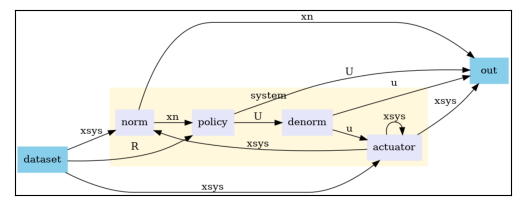

In [10]:
sys.change_backend('torch')
# We will have to denormalize the policy actions according to the system stats
# Conversely we will have to normalize the system states according to the system stats to hand to the policy

def norm(x):
    return sys.normalize(x, key='X')

def denorm(u):
    return sys.denormalize(u, key='U')

normnode = Node(norm, ['xsys'], ['xn'], name='norm')
denormnode = Node(denorm, ['U'], ['u'], name='denorm')
sysnode = Node(sys, ['xsys', 'u'], ['xsys'], name='actuator')
test_system = System([normnode, policy_node, denormnode, sysnode])
test_system.show()


## Evaluate on 1000 steps with a new reference trajectory distribution

{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1, 3]), 'Time': (1, 1000, 1)}


/mnt/c/Users/tuor369/gitland/torchdiffeq/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'grid_points': tensor([0.0000, 0.1000]), 'eps': 1e-06}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/mnt/c/Users/tuor369/gitland/neuromancer_wwu/neuromancer/src/neuromancer/psl/base.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)


{'R': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1001, 3]), 'Time': (1, 1000, 1), 'xn': torch.Size([1, 1000, 3]), 'U': torch.Size([1, 1000, 3]), 'u': torch.Size([1, 1000, 3])}


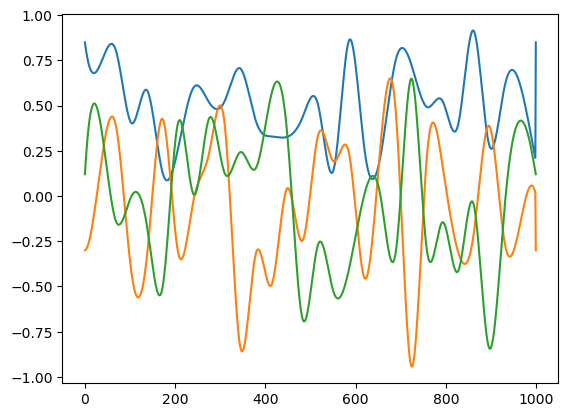

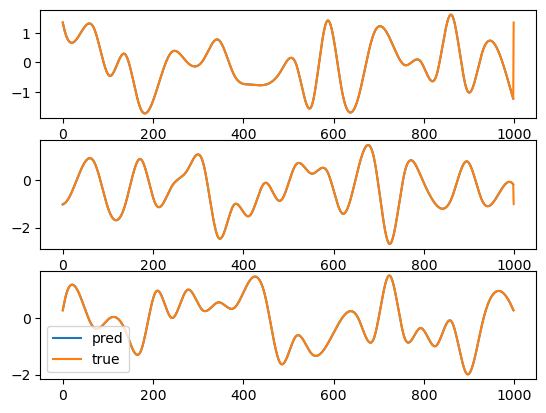

In [11]:
from neuromancer.psl.signals import sines, step, arma, spline
import numpy as np
references = spline(nsim=1000, d=sys.nx, min=sys.stats['X']['min'], max=sys.stats['X']['max'])
plt.plot(references)
test_data = {'R': torch.tensor(sys.normalize(references, key='X'), dtype=torch.float32).unsqueeze(0), 'xsys': sys.get_x0().reshape(1, 1, -1),
            'Time': (np.arange(1000)*sys.ts).reshape(1, 1000, 1)}
print({k: v.shape for k, v in test_data.items()})
test_system.nsteps=1000
with torch.no_grad():
    test_out = test_system(test_data)

print({k: v.shape for k, v in test_out.items()})
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_out['xn'][0, 1:, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['R'][0, :, v].detach().numpy(), label='true')
plt.legend()
plt.savefig('control.png')
